Acknowledgement: Some of the material was borrowed from Dan Sheldon, CMU

In [44]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
import sklearn.kernel_ridge
import sklearn.metrics.pairwise
from matplotlib.colors import ListedColormap
import numpy.linalg as la

In [26]:
## Globals
fs=20
lw=4


## Kernel Methods
### Example 1: Nonlinear Regression

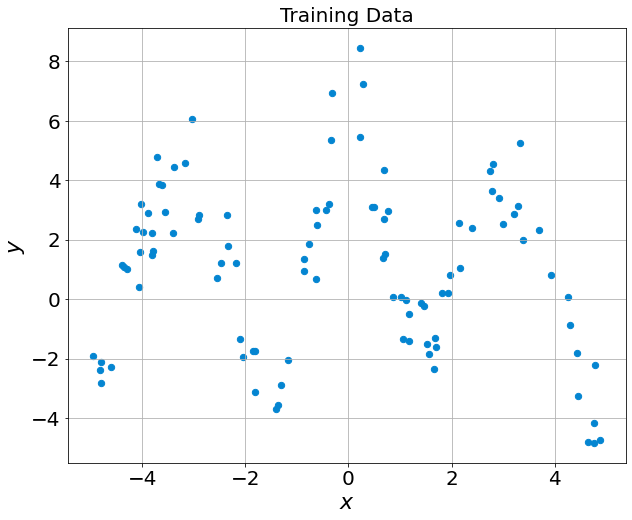

In [57]:
# Set random seed
np.random.seed(0)

# Create random set of m training x values between -5 and 5
m = 100
x_train = np.random.rand(m)*10 - 5   

# Create evenly spaced test x values (for plotting)
x_test  = np.linspace(-5, 5, 100)
m_test  = len(x_test);

def f1(x):
    return 0.1*(x + x**2 + 10*x + 0.5*x**2 - 0.5*x**3)*x

def f2(x):
    return 0.5*np.cos(x) + np.sin(x) + 4*np.cos(2*x) + np.exp(np.cos(3*x))


y_train = f2(x_train) + np.random.randn(m)   # polynomial plus noise

# Plot the training data
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=40, color='xkcd:cerulean')
plt.title('Training Data', fontsize=fs)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)
plt.show()


### Standard Linear Regression
Let's furst run standard linear regression. We will just use sklearn to do this, but you can easily do this with methods we saw in the previous lectures.

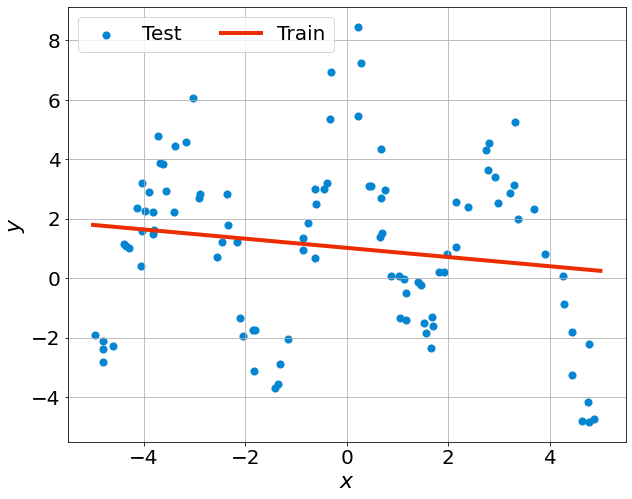

In [67]:
# to use sklearn, we need the data to be in the right shape
#x_train=x_train.reshape(-1,1)
#y_train=y_train.reshape(-1,1)
#x_test=x_test.reshape(-1,1)
clf = sklearn.linear_model.LinearRegression()
clf.fit(x_train, y_train)

y_test = clf.predict(x_test)

plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=50, color='xkcd:cerulean')
plt.plot(x_test, y_test, color='xkcd:tomato red', linewidth=lw)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)

plt.legend(['Test', 'Train'], fontsize=fs, ncol=2, loc=2)


### Kernel Trick for Linear Regression
Suppose  $\theta$ can be rewritten as a linear combination of the feature vectors---i.e., $\theta = \sum_{i=1}^m \alpha_i x^{(i)}$. Then, we have that
$$f(x) = \theta^\top x = \sum_{i=1}^m \alpha_i (x^{(i)})^\top x = \sum_{i=1}^m \alpha_i K(x^{(i)}, x)$$
where $K(x,z):=x^\top z$ is the kernel function and computes the dot product between $x$ and $z$. 

As we saw in lecture,e can rewrite this one more time to get
$$f(x) = \sum_{i=1}^m \alpha_i K(x^{(i)}, x) = \alpha^\top k(x)$$
where
\begin{aligned}
\alpha &= \begin{bmatrix}\alpha_1, \ldots, \alpha_m\end{bmatrix}^\top \\
 k(x) &= \begin{bmatrix}K(x^{(1)}, x), & K(x^{(2)}, x), & \ldots, & K(x^{(m)},x)\end{bmatrix}^\top
\end{aligned}
We can think this as a new linear regression problem with parameter vector  $\alpha$  and a feature mapping that maps  $x$  to the vector  $k(x)$  of kernel comparisons between  $x$  and every training point.

Applying the feature mapping to every row of the original data matrix  $X$  yields a "kernel matrix"  $K$  defined by  $K_{ij}=K(x^{(i)},x^{(j)})$.

If our assumption holds that the best  $\theta$  (the one that achieves minimum cost) can be expressed as a linear combination of feature vectors, then there is some choice for the parameter vector  $\alpha$ that will yield this best hypothesis. So, it suffices to look values of  $\alpha$  that minimize the squared error in this new linear regression problem. That is, we can simply solve the new linear regression problem where we replace the data matrix by the kernel matrix!

Note: this is not generally how we solve for  $\alpha$  in practice, but it is concrete proof that we can solve the learning and prediction problems while only accessing the data (feature vectors) through dot products.

In [63]:
x_test.flatten()

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

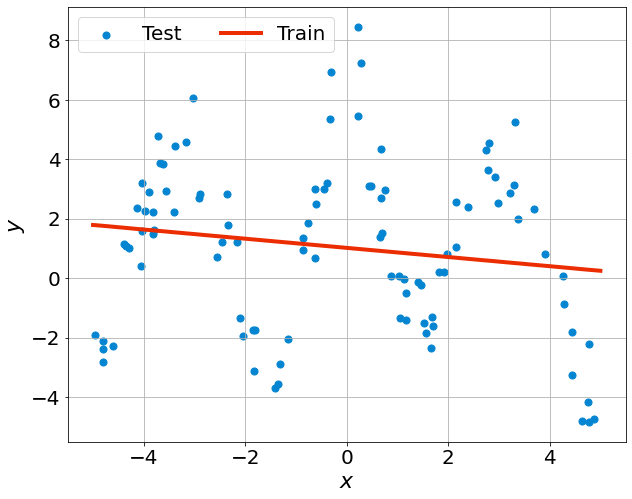

In [75]:
def linear_kernel(X, Z):
    '''
    Compute dot product between each row of X and each row of Z
    '''
    m1,_ = X.shape
    m2,_ = Z.shape
    K = np.zeros((m1, m2))
    for i in range(m1):
        for j in range(m2):
            K[i,j] = np.dot(X[i,:],Z[j,:])
            
    return K

K_train = linear_kernel(x_train, x_train) + 1e-10 * np.eye(m)  # see note below
K_test  = linear_kernel(x_test,  x_train)

clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)

y_test=clf.predict(K_test)
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=50, color='xkcd:cerulean')
plt.plot(x_test, y_test, color='xkcd:tomato red', linewidth=lw)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)

plt.legend(['Test', 'Train'], fontsize=fs, ncol=2, loc=2)

### [Optional] Why do we add 1e-10*np.eye(m) to K_train?

It turns out that our assumption that $\theta = \sum_{i=1}^m \alpha_i x^{(i)}$ needs to be refined slightly.
Let's consider the parameter vector $\theta^\ast$ that minimizes $$F(\theta) = \frac{1}{2}\sum_{i=1}^m \big(\theta^\top x^{(i)} - y^{(i)}\big)^2$$
It is true that there is **some** $\alpha$  such that $\theta^* = \sum_{i=1}^m K(x^{(i)}, x)$. So, we can minimize the cost function by searching over  $\alpha$  instead. However, there might be **many** different vectors  $\alpha$ that achieve the same cost, so minimizing
$$F(\alpha)=\frac{1}{2}\sum_{i=1}^m(\alpha^\top k(x^{(i)})-y^{(i)})^2$$ is not guaranteed to find the vector  $\alpha$  that corresponds to  $\theta^\ast$. However, if we instead add even a tiny bit of regularization to our training objective, we are guaranteed to exactly recover $\theta^\ast$---i.e., 
$$\frac{1}{2}\sum_{i=1}^m(\alpha^\top k(x^{(i)})-y^{(i)})^2+\frac{1}{2}\cdot1e\text{-}10\cdot\|\alpha\|^2$$
This is a result known as the representer theorem.




### Polynomial Kernel

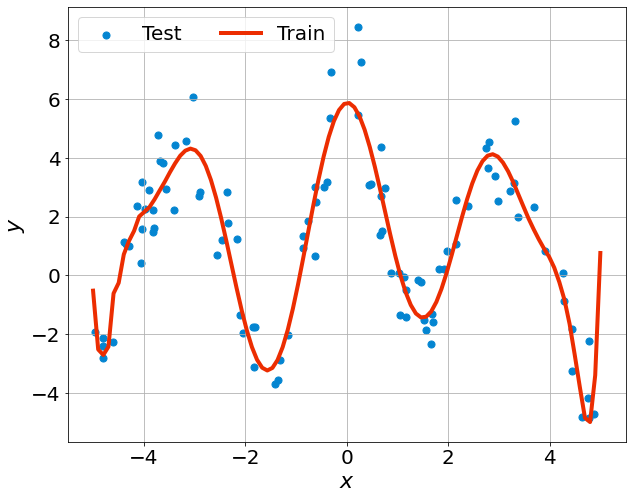

In [76]:
# Explicit definition
def polynomial_kernel(X, Z, d):
    '''
    Compute dot product between each row of X and each row of Z
    '''
    m1,_ = X.shape
    m2,_ = Z.shape
    K = np.zeros((m1, m2))
    for i in range(m1):
        for j in range(m2):
            K[i,j] = (np.dot(X[i,:], Z[j,:]) + 1)**d
            
    return K


# Better version: use sklearn.metrics.pairwise.polynomial_kernel

d = 12
K_train = sklearn.metrics.pairwise.polynomial_kernel(x_train, x_train, degree=d)
K_test  = sklearn.metrics.pairwise.polynomial_kernel(x_test,  x_train, degree=d)

K_train = K_train + 1e-10*np.eye(m)

clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)
y_test = clf.predict(K_test)
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=50, color='xkcd:cerulean')
plt.plot(x_test, y_test, color='xkcd:tomato red', linewidth=lw)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)

plt.legend(['Test', 'Train'], fontsize=fs, ncol=2, loc=2)

### Gaussian Kernel
$$K(x, z) = \exp (- \gamma \|x - z\|^2 )$$
Intepret as similarity function
- Equal to $1$ when  $x=z$ 
- Decays exponentially as  $z$  and  $x$  get farther apart
- Smaller  $\gamma$  $\implies$ slower decay
- Larger  $\gamma$  $\implies$ faster decay


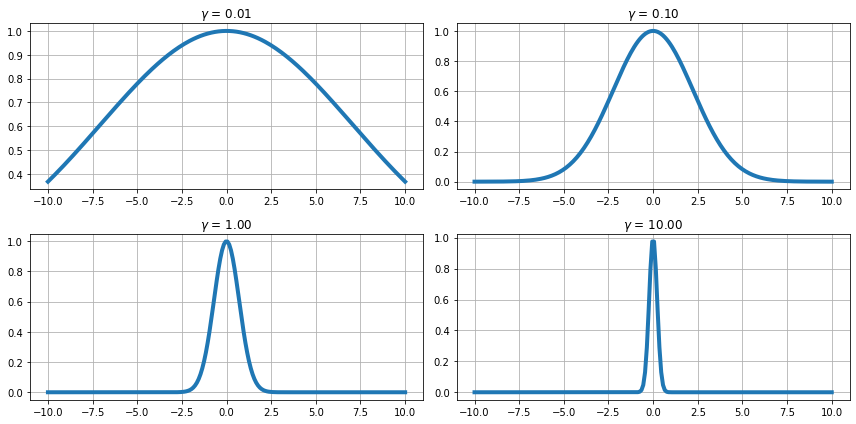

In [82]:
gamma_vals = [0.01, 0.1, 1, 10]

x    = np.linspace(-10, 10, 200).reshape(-1,1)
zero = np.array([[0]])

n_plots = len(gamma_vals)

plt.figure(figsize=(12, 6))

for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    k = sklearn.metrics.pairwise.rbf_kernel(x, zero, gamma=gamma_vals[i])
    plt.plot(x, k, lw=4)
    plt.title(r'$\gamma$ = %.2f' % (gamma_vals[i]))
    plt.grid(True)
plt.tight_layout()

### Linear Regression with Gaussian Kernel

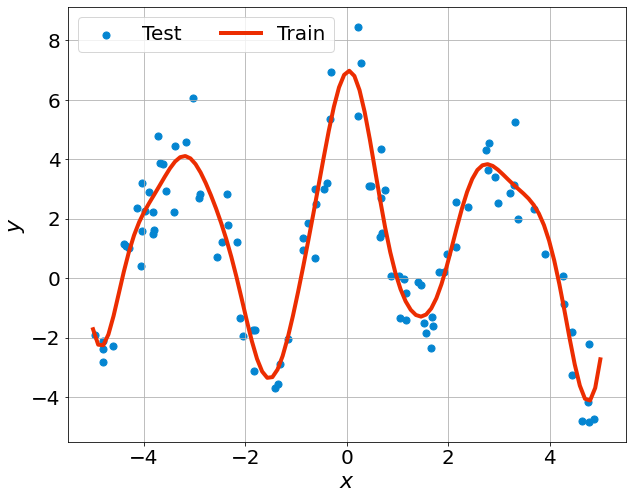

In [83]:
#gamma = 1000
gamma = 1

# Matrix of similarities between training points
K_train = sklearn.metrics.pairwise.rbf_kernel(x_train, x_train, gamma=gamma) + 1e-2*np.eye(m)

# ith row = similarity of ith test point to all training points
K_test  = sklearn.metrics.pairwise.rbf_kernel(x_test,  x_train, gamma=gamma) 

clf = sklearn.linear_model.LinearRegression()
clf.fit(K_train, y_train)
y_test = clf.predict(K_test)
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=50, color='xkcd:cerulean')
plt.plot(x_test, y_test, color='xkcd:tomato red', linewidth=lw)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)

plt.legend(['Test', 'Train'], fontsize=fs, ncol=2, loc=2)

### Linear Regression with Gaussian Kernel and Regularization
Tips: 
- use regularization with kernel methods. 
- don't form the kernel matrix yourself. Use an optimization routine that allows you to specify the kernel.

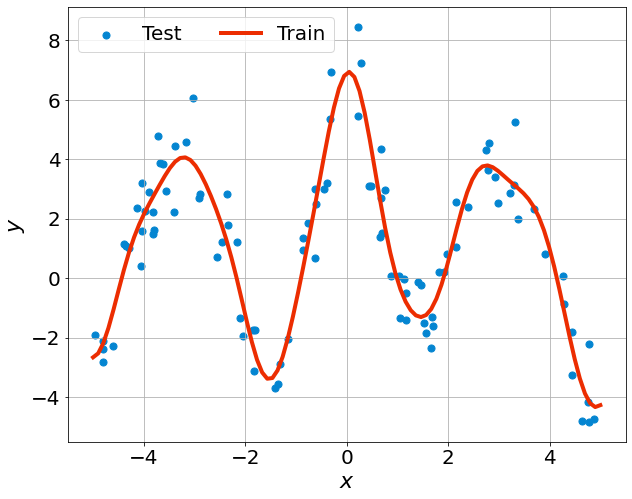

In [85]:
from sklearn import kernel_ridge

lambda_val = 0.01
gamma = 1

clf = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)
clf.fit(x_train, y_train)
y_test = clf.predict(x_test)
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(x_train, y_train, s=50, color='xkcd:cerulean')
plt.plot(x_test, y_test, color='xkcd:tomato red', linewidth=lw)
plt.xlabel(r'$x$', fontsize=fs+2)
plt.ylabel(r'$y$', fontsize=fs+2)
plt.tick_params(labelsize=fs)

plt.legend(['Test', 'Train'], fontsize=fs, ncol=2, loc=2)

## Example 2: 2D Nonlinear Classification

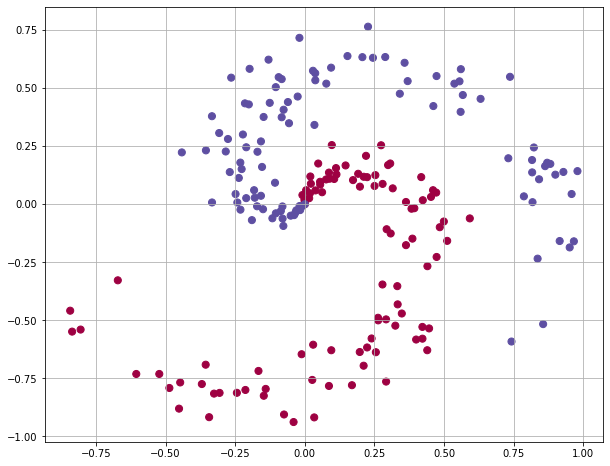

In [90]:
N = 100  # number of points per class
D = 2   # dimensionality
K = 2   # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K) # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.4 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

# lets visualize the data:
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Spectral)

In [113]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]
labels=['or','ob']

def plot_model(X_test, clf, figsize=None):
    Z = clf.predict(X_test)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    if figsize!=None:
        plt.figure(figsize=figsize)

    # Plot also the training points
    #plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    for i in [0, 1]:
        plt.plot(X[y==i, 0], X[y==i, 1], labels[i])
    plt.xlabel(r'$x_1$', fontsize=fs)
    plt.ylabel(r'$x_2$', fontsize=fs)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #plt.contourf(xx, yy, Z, alpha=1, cmap=cmap_light)
    plt.pcolormesh(xx, yy, Z,cmap=cmap_light)

### Kernelized Logistic Regression


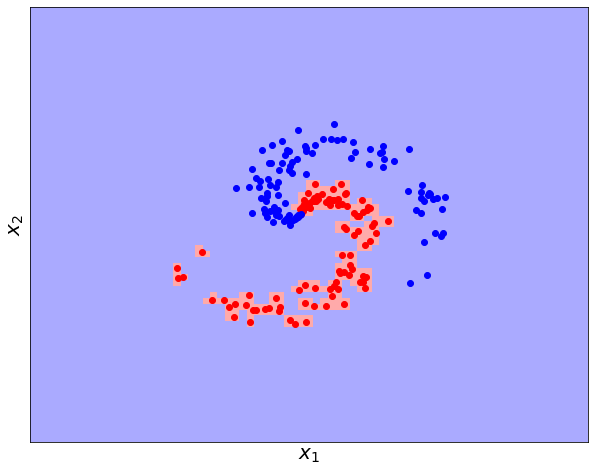

In [114]:
#gamma = 0.01
#gamma = 0.1
#gamma = 1
gamma = 10
gamma = 1000

K      = sklearn.metrics.pairwise.rbf_kernel(X, X, gamma=gamma)
K_test = sklearn.metrics.pairwise.rbf_kernel(X_test, X, gamma=gamma)

clf = sklearn.linear_model.LogisticRegression(solver='lbfgs')
clf.fit(K, y)

plot_model(K_test, clf, figsize=(10,8))

### SVM Loss Function


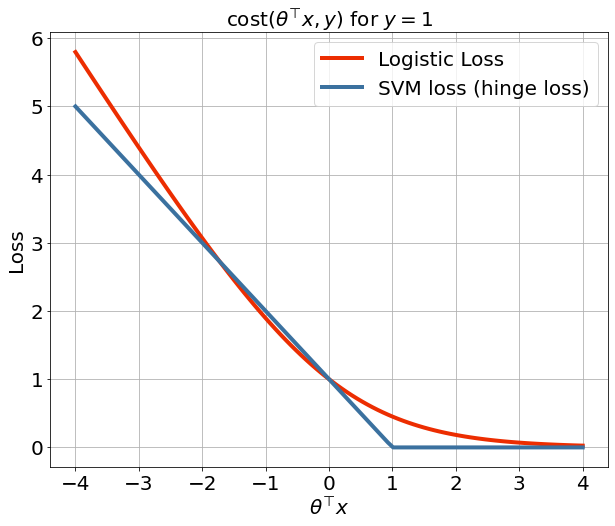

In [109]:
def plot_loss():
    xmin, xmax = -4, 4
    xx = np.linspace(xmin, xmax, 100)

    plt.figure(figsize=(10,8))
    plt.grid(True)
    plt.plot(xx, np.log2(1 + np.exp(-xx)), '-',color='xkcd:tomato red',linewidth=lw)
    plt.plot(xx, np.where(xx < 1, 1 - xx, 0), '-',color='xkcd:muted blue', linewidth=lw)
    plt.xlabel(r"$\theta^\top x$", fontsize=fs)
    plt.ylabel("Loss", fontsize=fs)
    plt.legend(["Logistic Loss", "SVM loss (hinge loss)"], fontsize=fs)
    plt.title(r"cost($\theta^\top x, y)$ for $y = 1$", fontsize=fs)
    plt.tick_params(labelsize=fs)
    plt.show()
    
plot_loss()

### SVM Classification


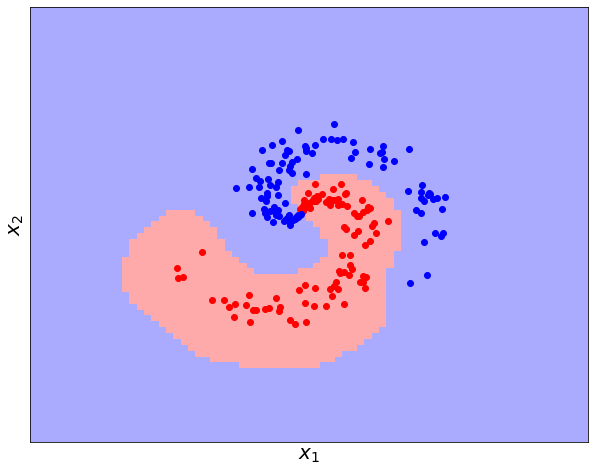

In [115]:

#gamma = 0.01
#gamma = 0.1
#gamma = 1
gamma = 10

C = 10 # C = 2/lambda

clf = sklearn.svm.SVC(C=C, kernel='rbf', gamma=gamma)
clf.fit(X, y)
plot_model(X_test, clf, figsize=(10,8))


### SVM vs Kernelized Logistic Regression


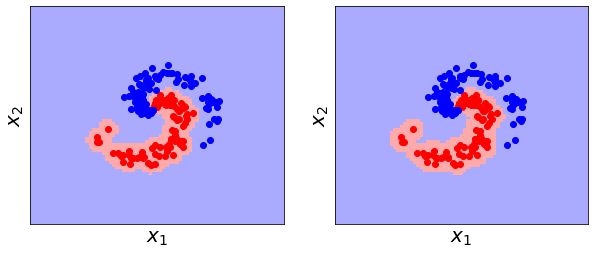

In [116]:
C = 1000
gamma = 100

# Fit kernelized logistic regression
K      = sklearn.metrics.pairwise.rbf_kernel(X, X, gamma=gamma)
K_test = sklearn.metrics.pairwise.rbf_kernel(X_test, X, gamma=gamma)
logistic = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')
logistic.fit(K, y)

# Fit SVM with same parameter
svm = sklearn.svm.SVC(C=C, kernel='rbf', gamma=gamma)
svm.fit(X, y)

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(K_test, logistic)

plt.subplot(122)
plot_model(X_test, svm)